In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [0]:
from torch.utils.data.dataset import Dataset
from torch.distributions.categorical import Categorical
from PIL import Image

class ImageConverter(Dataset):
  def __init__(self, data, transform):
    self.distribution = Categorical(torch.tensor([0.25, 0.25, 0.25, 0.25]))
    self.transform = transform
    self.X = data 
    self.y = rot_labels(data.shape[0], self.distribution)
  def __getitem__(self, index):
    x = self.X[index]
    #x = x.reshape(3, x.shape[0], x.shape[1])
    x = self.transform(x)
    x = apply_color_rot(x, self.y[index])
    #x = x.repeat(3, 1, 1)
    i = int(self.y[index].item())
    y_t = [0, 0, 0, 0]
    y_t[i] = 1
    return x.to(dtype=torch.float), torch.Tensor(y_t) 
  def __len__(self):
    return self.X.shape[0]
    
    

In [0]:
def apply_rot(x, y):
  if type(x) != torch.Tensor:
    x = torch.Tensor(x)
  if y == 3: 
    x = x.flip(1).t()
  elif y == 2: 
    x = x.flip(0).flip(1)
  elif y == 1:
     x = x.t().flip(1)
  return x

def apply_color_rot(x, y):
  x = torch.Tensor(x)
  for i, channel in enumerate(x):
    if y == 3: 
       x[i] = x[i].flip(1).t()
    elif y == 2: 
       x[i] = x[i].flip(0).flip(1)
    elif y == 1:
      x[i] = x[i].t().flip(1)
  return x

def rot_labels(length, dist):
  return torch.Tensor([dist.sample() for x in range(0, length)])

In [0]:
import scipy

import torchvision
import torchvision.transforms as transforms
import numpy as np

batch_size = 256
image_dim = 784
img_size = 224


#!rm -r data/

transf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(), 
    ])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                download=True, transform=None)


train_all = ImageConverter(train_dataset.data, transf)
test_all = ImageConverter(test_dataset.data, transf)


0it [00:00, ?it/s]

100%|█████████▉| 170385408/170498071 [02:08<00:00, 946999.19it/s]

Files already downloaded and verified


In [0]:
def get_loaders():
    valid_size=0.2
    random_seed = 32
    shuffle = True
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
   
    
    train_loader = torch.utils.data.DataLoader(train_all,
                          batch_size=256,
                          num_workers=1,
                          sampler=train_sampler
                         )

    valid_loader = torch.utils.data.DataLoader(train_all,
                          batch_size=256,
                          num_workers=1,
                          sampler=valid_sampler
                         )   
    
    test_loader = torch.utils.data.DataLoader(test_all,
                          batch_size=256,
                          shuffle=True,
                          num_workers=1,
                         )   
    return train_loader, valid_loader, test_loader
  
  
train_loader, valid_loader, test_loader = get_loaders() 

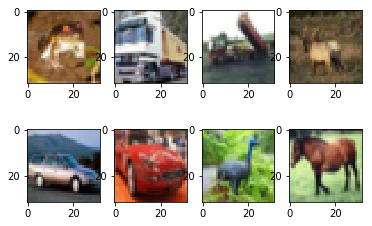

(50000, 32, 32, 3)


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

for i in range(8):
    plt.subplot(int(str(24)+str(i+1)))
    plt.imshow(train_dataset.data[i], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

print(train_dataset.data.shape)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import numpy as np

class MLP(nn.Module):
    '''
    simple encoder with a single hidden dense layer
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(MLP, self).__init__()
      self.fc = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, output_dim)
      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()
      
    def forward(self, x):
      fc = self.fc(x)
      fc2 = self.fc2(self.relu(fc))
      return self.sigmoid(fc2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(torch.nn.Module):
  
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18 * 14 * 14, 64)
        self.fc2 = torch.nn.Linear(64, 4)
        self.sig = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 18 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.sig(self.fc2(x))
        return(x)

In [0]:
import torchvision.models as models

alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = nn.Linear(4096, 4)


In [0]:
!pip install torchbearer

import torchbearer
from torchbearer import Trial
from torchbearer.callbacks.decorators import on_end_epoch
from torch import optim


model = alexnet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-3)
  
def sigcross(x, y):
  return F.binary_cross_entropy(torch.sigmoid(x), y, size_average=False) / x.shape[0]
  
 
torchbearer_trial = Trial(model, optimizer, criterion=sigcross,  metrics=['loss']).to(device)
torchbearer_trial.with_generators(train_generator=train_loader, val_generator=valid_loader, test_generator=test_loader)
torchbearer_trial.run(epochs=20)
torchbearer_trial.predict()

     |████████████████████████████████| 92kB 3.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/6c/cb/69/466aef9cee879fb8f645bd602e34d45e754fb3dee2cb1a877a
Successfully built torchbearer


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Exception ignored in: <bound method tqdm.__del__ of 170500096it [07:06, 946999.19it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


tensor([[ 0.2113, -1.7671, -1.1906, -2.2797],
        [-4.6482, -6.1640,  4.1312, -6.8261],
        [-1.7420, -1.6199,  0.5475, -2.3753],
        ...,
        [-1.2422, -1.2741, -0.4361, -1.5431],
        [-3.5052, -4.3738,  2.7907, -4.5111],
        [-1.0930, -2.2783,  0.3814, -2.2936]], device='cuda:0')

In [0]:
images, labels = iter(test_loader).next()

In [0]:
model.eval()
output = model(images.to(device))
predictions = []
label = []
for i, x in enumerate(output.detach().cpu()):
  predictions.append(np.argmax(x))
  label.append(np.argmax(labels[i]))

In [0]:
total = 0
count = 0
incorrect = []
for i, x in enumerate(predictions):
  if x == label[i]: 
    count+=1
  else: 
    incorrect.append(i)
  total+=1

print(count/total)
  

0.62890625


In [0]:
incorrect

[0,
 2,
 3,
 5,
 8,
 11,
 13,
 15,
 17,
 21,
 25,
 29,
 31,
 38,
 47,
 48,
 49,
 50,
 51,
 54,
 61,
 66,
 69,
 70,
 71,
 73,
 74,
 78,
 88,
 91,
 92,
 96,
 101,
 103,
 105,
 107,
 112,
 115,
 117,
 120,
 123,
 126,
 129,
 135,
 137,
 141,
 143,
 145,
 146,
 147,
 149,
 152,
 156,
 161,
 163,
 164,
 165,
 169,
 171,
 173,
 176,
 179,
 182,
 183,
 185,
 189,
 190,
 192,
 194,
 195,
 196,
 197,
 198,
 199,
 203,
 205,
 206,
 210,
 211,
 212,
 213,
 214,
 216,
 217,
 220,
 222,
 223,
 227,
 228,
 230,
 232,
 235,
 237,
 238,
 239,
 241,
 245,
 246,
 248,
 252]

torch.Size([224, 224, 3])
Actual Label: 0
Predicted Label: 3


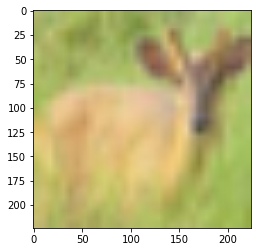

In [0]:

index = 6
img = images[index].permute(1,2,0)
print(img.shape)
plt.imshow(img, cmap=plt.get_cmap('gray'))
print("Actual Label:", label[index].item())
print("Predicted Label:", predictions[index].item())

In [0]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [0]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

tensor(0)


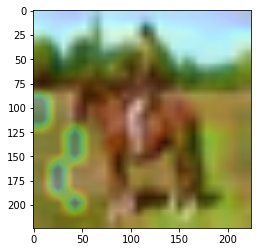

In [0]:
import skimage.transform
from matplotlib.pyplot import imshow


layer = 6
rot = 2


hook = model.features[layer].register_forward_hook(get_activation('6'))
x = images[ind].reshape(1, 3, 224, 224)
output = model(x.to(device))
hook.remove()
for i, a in enumerate(output.detach().cpu()):
  predictions.append(np.argmax(a))
  
heatmap = torch.mean(activation['6'], dim=1).squeeze()
heatmap = np.maximum(heatmap.cpu(), 0)
heatmap /= torch.max(heatmap.cpu())
#plt.matshow(heatmap.squeeze())
#plt.show()
x = x.reshape(3, 224, 224)
#plt.imshow(x.permute(1, 2, 0), cmap=plt.get_cmap('gray'))
#plt.show()
print(predictions[0])

pil = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    ])


heatmap = pil(apply_rot(-heatmap, rot))


im1 = plt.imshow(apply_rot(x.permute(1,2,0), rot), cmap=plt.cm.gray)
im2 = plt.imshow(heatmap, cmap='jet', alpha=.2)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-1.2089, -1.1116, -1.1286, -1.2310, -1.1964, -1.0888, -1.1966,
          -1.2228, -1.1403, -1.2361, -1.2856],
         [-1.2117, -1.1148, -1.2562, -1.1007, -1.0819, -1.1825, -1.0387,
          -1.0792, -1.1963, -1.1461, -1.2415],
         [-1.2039, -1.1428, -1.2102, -1.2374, -1.0875, -1.0532, -1.0308,
          -1.0469, -1.1828, -1.0956, -1.1439],
         [-1.1282, -1.1072, -1.1333, -1.1431, -1.0808, -1.1975, -1.2166,
          -1.2171, -1.0545, -1.1036, -1.0814],
         [-1.1800, -1.2330, -1.1230, -1.2294, -1.2370, -1.1387, -1.2302,
          -1.1307, -1.1015, -1.2377, -1.1545],
         [-1.2373, -1.2447, -1.1682, -1.2663, -1.2185, -1.2581, -1.1400,
          -1.1947, -1.2004, -1.2895, -1.1466],
         [-1.1129, -1.2305, -1.2234, -1.2686, -1.1231, -1.2237, -1.1565,
          -1.0757, -1.0964, -1.2509, -1.2036],
         [-1.1595, -1.0923, -1.0120, -1.1066, -1.1034, -1.2208, -1.1230,
          -1.1602, -1.2634, -1.1460, -1.1300],
         [-1.1234, -1.2019, -1.0668, -1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

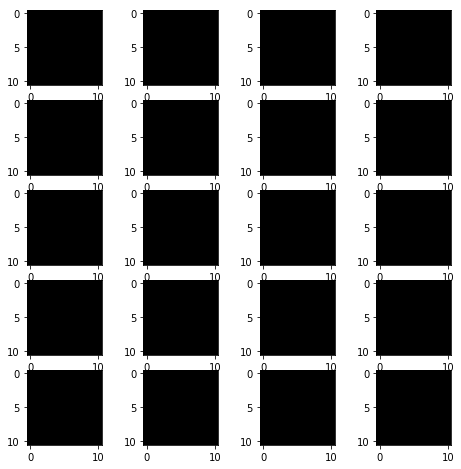

In [0]:
weights = list(model.features[0].weight)
weights = np.asarray(weights)

norm = transforms.Compose([
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for i, w in enumerate(weights):
  weights[i] = norm(w.detach().cpu())

print(weights[0])
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = weights[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.detach().cpu().permute(1, 2, 0))
plt.show()

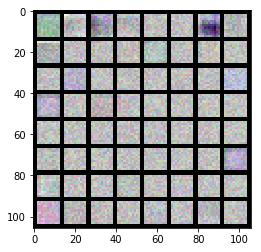

In [0]:
from torchvision.utils import make_grid

kernels = model.features[0].weight.detach().clone().cpu()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

In [0]:

from torchvision import utils

def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

torch.Size([64, 3, 11, 11])


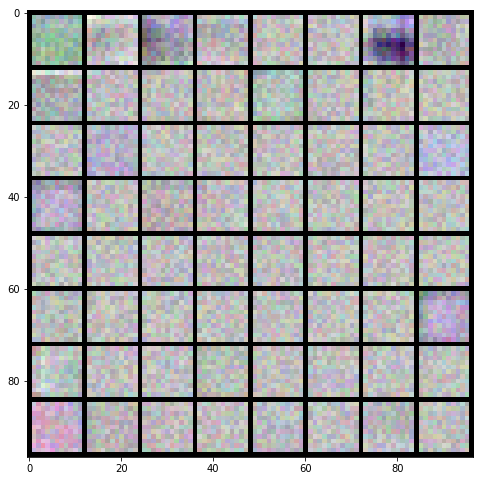

In [0]:
kernel = alexnet.features[0].weight.data.clone()
print(kernel.shape)
vistensor(kernel.cpu()*0.1, ch=0, allkernels=False)